## Описание проекта

**Описание проекта:**

Компания «В один клик» столкнулась с проблемой снижения покупательской активности постоянных клиентов. Основная цель проекта — разработать модель, которая предскажет вероятность снижения покупательской активности клиента, а также выделить клиентские сегменты для разработки персонализированных предложений, способствующих повышению активности.

**Цель проекта:**

- Построить модель, предсказывающую вероятность снижения покупательской активности клиентов.
- Проанализировать выделенные сегменты покупателей и предложить стратегии для увеличения их активности, опираясь на данные модели и показатели прибыльности.

**Ход исследования:**

1. [Загрузка и изучение данных](#загрузка)

- Импорт данных из предоставленных таблиц.
- Проверка соответствия данных описанию.

2. [Предобработка данных](#предобработка)

- Очистка и обработка данных (устранение пропусков, аномалий, корректировка форматов).
- Преобразование данных для дальнейшего анализа.

3. [Исследовательский анализ данных](#исследовательский)

- Анализ поведения клиентов, выручки, времени на сайте и других признаков.
- Выделение клиентов с активностью не менее трёх месяцев.

4. [Объединение данных](#объединение)

- Создание итоговой таблицы путём объединения данных из различных источников.
- Преобразование признаков выручки и времени на сайте в отдельные столбцы для каждого периода.

5. [Корреляционный анализ](#корреляционный)

- Анализ мультиколлинеарности количественных признаков.
- Устранение избыточных признаков, если необходимо.

6. [Построение моделей с использованием пайплайнов](#построение)

- Подготовка данных через ColumnTransformer для обработки категориальных и количественных признаков.
- Обучение четырёх моделей (KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC).
- Настройка гиперпараметров с использованием подходящей метрики.
- Выбор лучшей модели.

7. [Анализ важности признаков](#анализ)

- Оценка значимости признаков с помощью метода SHAP.
- Выявление наиболее и наименее значимых признаков для модели.

8. [Сегментация клиентов](#сегментация)

- Выделение групп клиентов на основе модели и показателей прибыльности.
- Анализ выбранной группы и разработка рекомендаций для повышения её активности.

9. [Общий вывод](#общий)

- Описание выполненной работы, лучших моделей и предложений для выделенных сегментов клиентов.

**Описание данных:**

Для датасета `market_file.csv`:
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Для датасета `market_money.csv`:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

Для датасета `market_time.csv`:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

Для датасета `money.csv`:
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

<a id='загрузка'></a>
## Загрузка данных

**Импорт библиотек:**

In [1]:
!pip install -q imblearn
!pip install -q phik
!pip install -q shap
!pip install -q optuna
!pip install -q optuna.integration

In [2]:
import pandas as pd
import optuna
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cycler import cycler
import seaborn as sns

import numpy as np
from scipy import stats as st
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score

from optuna import distributions
from optuna.integration import OptunaSearchCV

from sklearn.inspection import permutation_importance
import shap

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

Константы:

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузка данных:

In [4]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=";", decimal=",")

In [5]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [7]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [9]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [11]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [12]:
money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

**Вывод:**

- Данные соответствуют описанию
- В данных нет пропусков

<a id='предобработка'></a>
## Предобработка данных

In [13]:
def detailed_df_analysis(df):
    """
    Создадим функцию, чтобы получить расширенную первичную информацию по таблице данных.
    
    """
    # Пропущенные значения
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    print("Пропущенные значения:")
    print(pd.DataFrame({'count': missing_values, 'percentage': missing_percent}), "\n")

    # Количество дубликатов строк
    duplicates = df.duplicated().sum()
    print(f"Количество дубликатов: {duplicates}\n")

    # Информация по категориальным столбцам
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("Информация о категориальных признаках:")
        for col in categorical_cols:
            unique_count = df[col].nunique()
            unique_values = df[col].unique()
            print(f"{col} => {unique_count} уникальных значений")
            for value in unique_values:
                print(f"  - {value}")
            print()
    else:
        print("Категориальные признаки отсутствуют.\n")

In [14]:
# Используем функцию на 4 датасетах
detailed_df_analysis(market_file)

Пропущенные значения:
                                     count  percentage
id                                       0         0.0
Покупательская активность                0         0.0
Тип сервиса                              0         0.0
Разрешить сообщать                       0         0.0
Маркет_актив_6_мес                       0         0.0
Маркет_актив_тек_мес                     0         0.0
Длительность                             0         0.0
Акционные_покупки                        0         0.0
Популярная_категория                     0         0.0
Средний_просмотр_категорий_за_визит      0         0.0
Неоплаченные_продукты_штук_квартал       0         0.0
Ошибка_сервиса                           0         0.0
Страниц_за_визит                         0         0.0 

Количество дубликатов: 0

Информация о категориальных признаках:
Покупательская активность => 2 уникальных значений
  - Снизилась
  - Прежний уровень

Тип сервиса => 3 уникальных значений
  - премиум
  - ст

Промежуточный вывод по датасету `market_file`:

- Нужно названия признаков перевести в snake_case для однородности
- В значении признака `Тип сервиса` нужно исправить опечатку `стандартт`

In [15]:
# Переводим столбцы в snake_case
market_file = market_file.rename(columns={
    'Покупательская активность': 'Покупательская_активность',
    'Тип сервиса': 'Тип_сервиса',
    'Разрешить сообщать': 'Разрешить_сообщать'
})

# Исправляем опечатку
market_file.loc[market_file['Тип_сервиса'] == 'стандартт', 'Тип_сервиса'] = 'стандарт'

# Проверяем датасет на все исправления:
detailed_df_analysis(market_file)

Пропущенные значения:
                                     count  percentage
id                                       0         0.0
Покупательская_активность                0         0.0
Тип_сервиса                              0         0.0
Разрешить_сообщать                       0         0.0
Маркет_актив_6_мес                       0         0.0
Маркет_актив_тек_мес                     0         0.0
Длительность                             0         0.0
Акционные_покупки                        0         0.0
Популярная_категория                     0         0.0
Средний_просмотр_категорий_за_визит      0         0.0
Неоплаченные_продукты_штук_квартал       0         0.0
Ошибка_сервиса                           0         0.0
Страниц_за_визит                         0         0.0 

Количество дубликатов: 0

Информация о категориальных признаках:
Покупательская_активность => 2 уникальных значений
  - Снизилась
  - Прежний уровень

Тип_сервиса => 2 уникальных значений
  - премиум
  - ст

In [16]:
detailed_df_analysis(market_money)

Пропущенные значения:
         count  percentage
id           0         0.0
Период       0         0.0
Выручка      0         0.0 

Количество дубликатов: 0

Информация о категориальных признаках:
Период => 3 уникальных значений
  - препредыдущий_месяц
  - текущий_месяц
  - предыдущий_месяц



Промежуточный вывод по датасету `market_money`:

- Нужно исправить опечатку в признаке `Период` `препредыдущий_месяц`

In [17]:
detailed_df_analysis(market_time)

Пропущенные значения:
        count  percentage
id          0         0.0
Период      0         0.0
минут       0         0.0 

Количество дубликатов: 0

Информация о категориальных признаках:
Период => 2 уникальных значений
  - текущий_месяц
  - предыдцщий_месяц



Промежуточный вывод по датасету market_money:

- Нужно исправить опечатку в признаке `Период` `предыдцщий_месяц`

In [18]:
market_time.loc[market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'

# Проверка исправления:
detailed_df_analysis(market_time)

Пропущенные значения:
        count  percentage
id          0         0.0
Период      0         0.0
минут       0         0.0 

Количество дубликатов: 0

Информация о категориальных признаках:
Период => 2 уникальных значений
  - текущий_месяц
  - предыдущий_месяц



In [19]:
detailed_df_analysis(money)

Пропущенные значения:
         count  percentage
id           0         0.0
Прибыль      0         0.0 

Количество дубликатов: 0

Категориальные признаки отсутствуют.



**Вывод:**

- пропущенных значений не обнаружено
- дубликатов тоже в данных нет
- типы параметров все верные
- имена параметров приведены к общему виду 
- исправлены опечатки

<a id='исследовательский'></a>
## Исследовательский анализ данных

- Изучим статистики всех таблиц и выбросы с помощью диаграммы "ящик с усами".
- Отберем клиентов с покупательской активностью не менее трёх месяцев

In [20]:
def plot_histograms_boxplots(df):
    """
    Строит гистограммы и ящики с усами для каждого числового столбца в DataFrame.

    """
    # Выбор числовых столбцов
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Если числовых столбцов нет, вывести сообщение и завершить функцию
    if len(numeric_cols) == 0:
        print("Числовые столбцы отсутствуют.")
        return

    # Количество строк и столбцов в сетке графиков
    num_cols = 2  # По два графика (гистограмма и boxplot) в строке
    num_rows = len(numeric_cols)

    # Создание фигуры
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Упрощаем доступ к осям
    
    # Построение графиков
    for i, col in enumerate(numeric_cols):
        # Гистограмма
        sns.histplot(df[col], bins=15, kde=False, ax=axes[2 * i])
        axes[2 * i].set_title(f'Histogram of {col}')
        axes[2 * i].set_xlabel(col)
        axes[2 * i].set_ylabel('Frequency')

        # Ящик с усами
        sns.boxplot(x=df[col], ax=axes[2 * i + 1])
        axes[2 * i + 1].set_title(f'Box Plot of {col}')
        axes[2 * i + 1].set_xlabel(col)

    # Убираем лишние пустые оси, если они есть
    for ax in axes[len(numeric_cols) * 2:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

In [21]:
def plot_countplots(df):
    """
    Строит countplots для каждого категориального фактора в DataFrame.

    """
    # Выбор категориальных столбцов
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Проверка наличия категориальных столбцов
    if len(categorical_cols) == 0:
        print("Категориальные столбцы отсутствуют.")
        return

    # Настройка сетки графиков
    num_cols = 2  # Количество графиков в строке
    num_rows = (len(categorical_cols) + num_cols - 1) // num_cols  # Округление вверх

    # Создание фигуры
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))
    axes = axes.flatten()  # Упрощаем доступ к осям

    # Построение countplots для каждого категориального столбца
    for i, col in enumerate(categorical_cols):
        sns.countplot(y=col, data=df, order=df[col].value_counts().index, ax=axes[i])
        axes[i].set_title(f'График для {col}')
        axes[i].set_xlabel('Количество')
        axes[i].set_ylabel(col)

    # Убираем лишние оси, если столбцов меньше, чем количество графиков
    for ax in axes[len(categorical_cols):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

Сделаем `id` индексами:

In [22]:
market_file = market_file.set_index('id')
market_money = market_money.set_index('id')
market_time = market_time.set_index('id')
money = money.set_index('id')

In [23]:
# Смотрим сводную статистическую информацию о числовых и категориальных данных 
market_file.describe()

Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
count         1300.000000           1300.000000   1300.000000   
mean             4.253769              4.011538    601.898462   
std              1.014814              0.696868    249.856289   
min              0.900000              3.000000    110.000000   
25%              3.700000              4.000000    405.500000   
50%              4.200000              4.000000    606.000000   
75%              4.900000              4.000000    806.000000   
max              6.600000              5.000000   1079.000000   

       Акционные_покупки  Средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

In [24]:
market_file.describe(include=['object'])

Покупательская_активность Тип_сервиса Разрешить_сообщать  \
count                       1300        1300               1300   
unique                         2           2                  2   
top              Прежний уровень    стандарт                 да   
freq                         802         924                962   

       Популярная_категория  
count                  1300  
unique                    6  
top        Товары для детей  
freq                    330

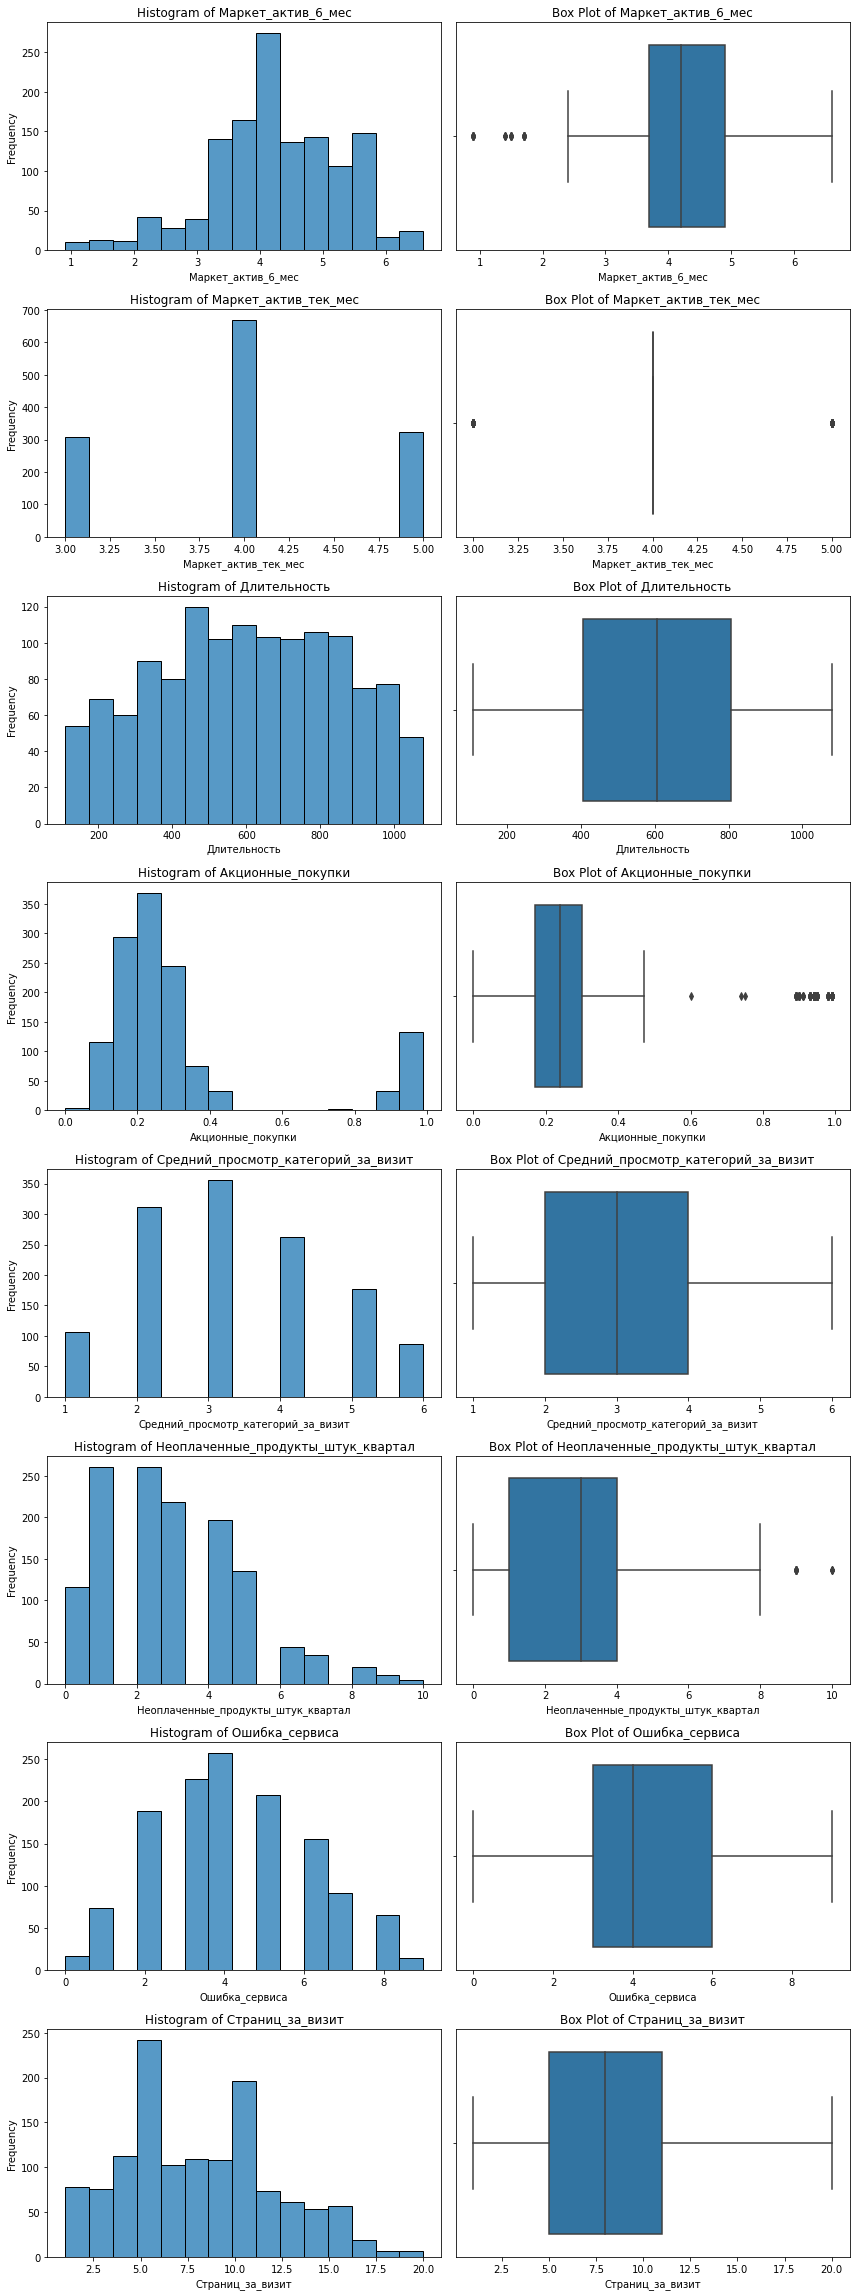

In [25]:
# Выводим графики для market_file
plot_histograms_boxplots(market_file)

В параметрах `Маркет_актив_6_мес`, `Акционные_покупки`, `Неоплаченные_продукты_штук_квартал` присутствуют выбросы

По диаграмме пораметра `Маркет_актив_6_мес` видим, что некоторое количество значений явно уходит за пределы первого квантиля. Сделаем из этого количественного признака категориальный:

- `Маркет_актив_6_мес_категориальный` - будет иметь значения низкий (меньше 2), средний (2 до 6), высокий (при выше 6).

In [26]:
# Копируем данные в новый столбец
market_file['Маркет_актив_6_мес_категориальный'] = market_file['Маркет_актив_6_мес'].apply(
    lambda x: 'низкий' if x < 2 else 'средний' if x <= 6 else 'высокий'
)

# Удаляем старый столбец
market_file.drop(columns='Маркет_актив_6_мес', inplace=True)

Диаграмма для параметра `Маркет_актив_тек_мес` имеет неправильное распределение их трех столбцов, потому что уникальных значений всего 3:

In [27]:
market_file['Маркет_актив_тек_мес'].unique()

array([5, 4, 3])

Переделаем в качественный признак.

In [28]:
market_file['Маркет_актив_тек_мес_категориальный'] = market_file['Маркет_актив_тек_мес'].apply(
    lambda x : 'низкий' if x < 3.5 else 'средний' if x <= 4.5 else 'высокий'
)

# Удаляем старый столбец
market_file.drop(columns='Маркет_актив_тек_мес', inplace=True)

In [29]:
market_file['Акционные_покупки'].unique()

array([0.  , 0.75, 0.14, 0.99, 0.94, 0.26, 0.23, 0.17, 0.13, 0.35, 0.74,
       0.29, 0.98, 0.95, 0.22, 0.4 , 0.24, 0.21, 0.39, 0.9 , 0.89, 0.27,
       0.33, 0.34, 0.32, 0.93, 0.3 , 0.28, 0.31, 0.25, 0.36, 0.16, 0.11,
       0.2 , 0.18, 0.15, 0.6 , 0.12, 0.19, 0.44, 0.47, 0.91])

Для параметра `Акционные_покупки` можно выделить категориальный признак с разделением в районе 0.7(> - высокий, < - низкий). Добавим этот признак:

In [30]:
market_file['Акционные_покупки_категориальный'] = market_file['Акционные_покупки'].apply(
    lambda x : 'низкий' if x < 0.7 else 'высокий'
)

# Удаляем старый столбец
market_file.drop(columns='Акционные_покупки', inplace=True)

Сделаем из `Неоплаченные_продукты_штук_квартал` категориальный разделив значения на низкий (меньше 1), средний (от 1 до 5), высокий (выше 5).

In [31]:
market_file['Неоплаченные_продукты_штук_квартал_категориальный'] = market_file['Неоплаченные_продукты_штук_квартал'].apply(
    lambda x : 'низкий' if x < 1 else 'средний' if x <= 5 else 'высокий'
)

# Удаляем старый столбец
market_file.drop(columns='Неоплаченные_продукты_штук_квартал', inplace=True)

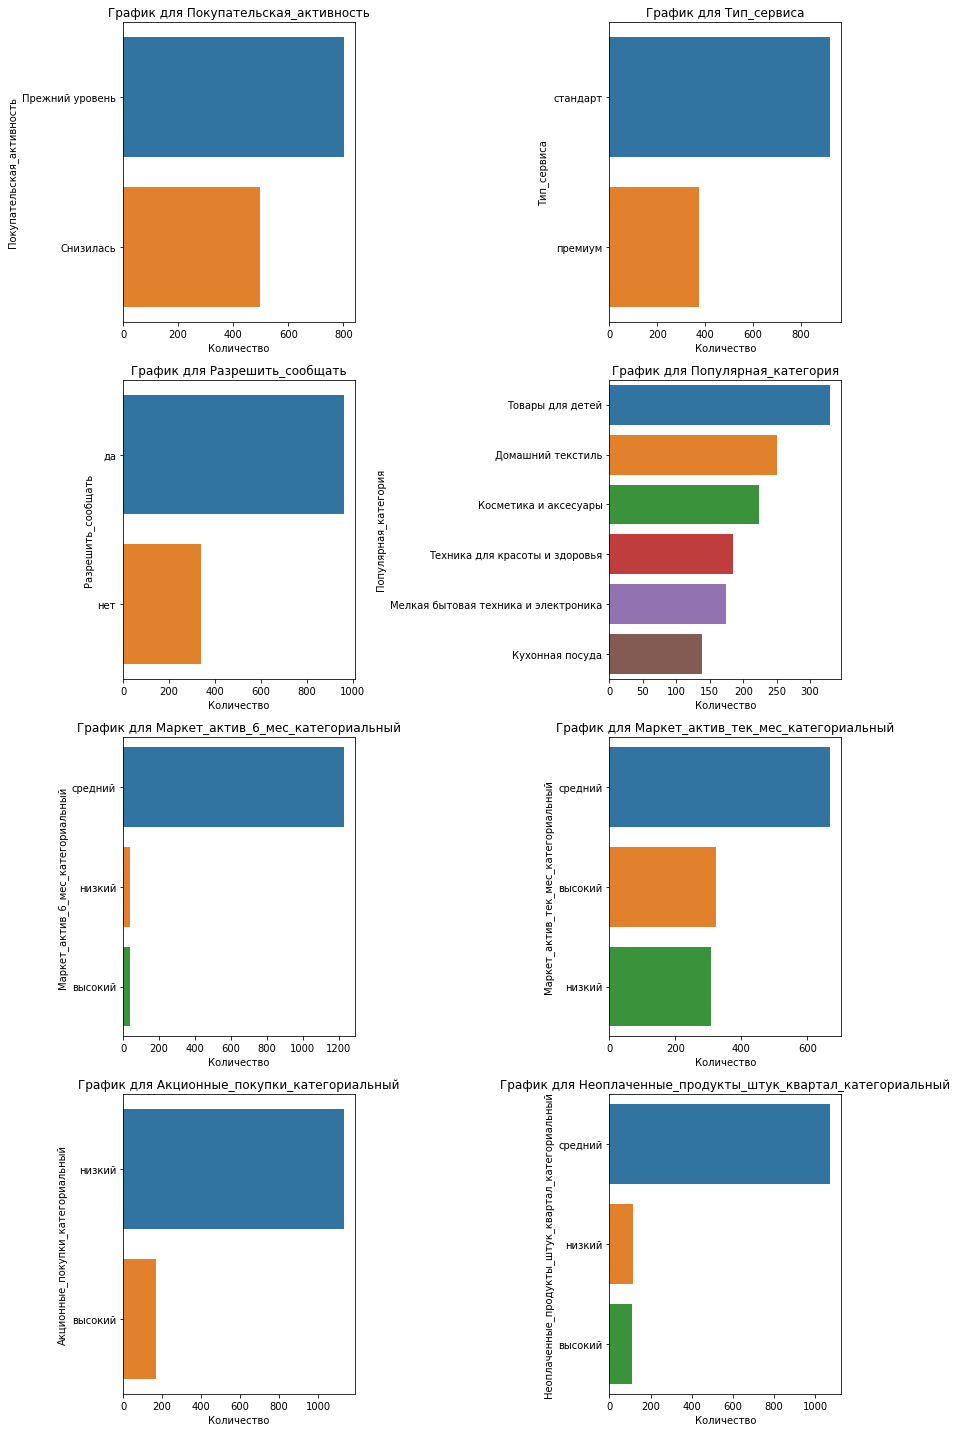

In [32]:
# Изучим распределение категориальных параметров
plot_countplots(market_file)

В параметрах: `Тип_сервиса`, `Разрешить_сообщать`, `Покупательская_активность` и `Акционные_покупки_категориальный` виден дисбаланс в значениях. 

In [33]:
# Смотрим сводную статистическую информацию о числовых и категориальных данных
market_money.describe()

Выручка
count    3900.000000
mean     5025.696051
std      1777.704104
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max    106862.200000

В данных явно присутсвует выброс, судя по разнице максимального значения и 75% данных.

In [34]:
market_money.describe(include=['object'])

Период
count            3900
unique              3
top     текущий_месяц
freq             1300

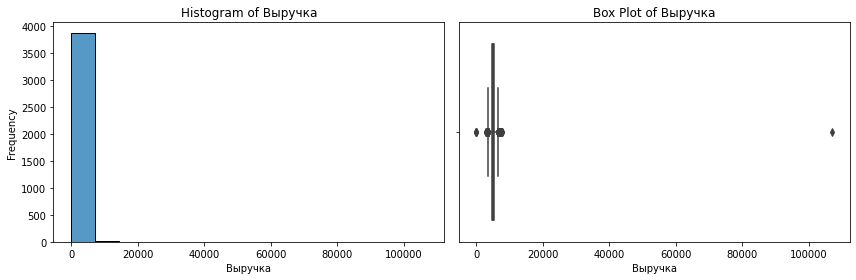

In [35]:
# Выводим графики для market_money
plot_histograms_boxplots(market_money)

Предположение потвердилось и график сплющило из-за выброса. Надо удалить его.

In [36]:
# Отсотритуем данные праматера по убывания и выведем первые пять значений
market_money.sort_values(by='Выручка', ascending=False).head()

Период   Выручка
id                             
215380  текущий_месяц  106862.2
215493  текущий_месяц    7799.4
215435  текущий_месяц    7605.3
215841  текущий_месяц    7557.0
216144  текущий_месяц    7547.8

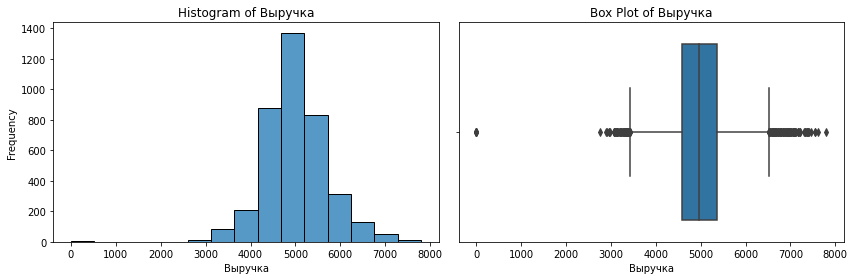

In [37]:
# Исключим самое высокое и нулевое значение параметра 
market_money = market_money[market_money['Выручка'] != 106862.2]

# Выведем снова графики
plot_histograms_boxplots(market_money)

Теперь значение 0 похож на выброс. Удалим.

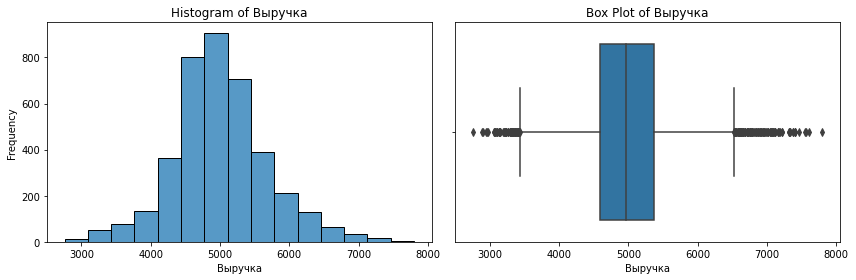

In [38]:
market_money = market_money[market_money['Выручка'] != 0]
plot_histograms_boxplots(market_money)

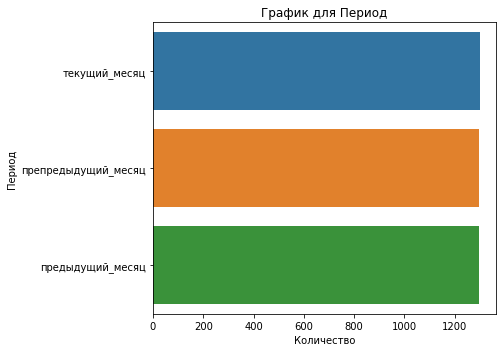

In [39]:
# Изучим распределение категориальных признаков
plot_countplots(market_money)

In [40]:
# Смотрим сводную статистическую информацию о числовых и категориальных данных 
market_time.describe()

минут
count  2600.000000
mean     13.336154
std       4.080198
min       4.000000
25%      10.000000
50%      13.000000
75%      16.000000
max      23.000000

In [41]:
market_time.describe(include=['object'])

Период
count            2600
unique              2
top     текущий_месяц
freq             1300

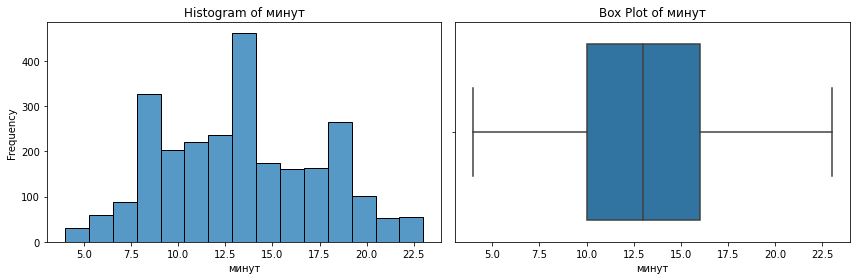

In [42]:
# Выводим графики для market_time
plot_histograms_boxplots(market_time)

Всё ок.

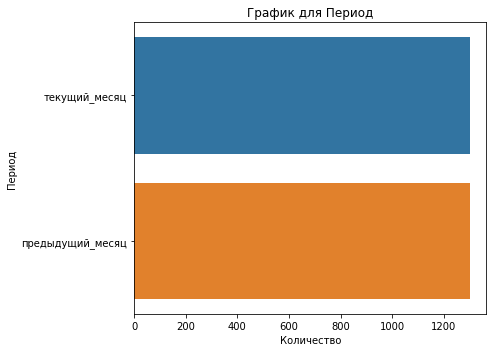

In [43]:
# Изучим распределение категориальных признаков
plot_countplots(market_time)

Интересно.

In [44]:
# Смотрим сводную статистическую информацию о числовых данных 
money.describe()

Прибыль
count  1300.000000
mean      3.996631
std       1.013722
min       0.860000
25%       3.300000
50%       4.045000
75%       4.670000
max       7.430000

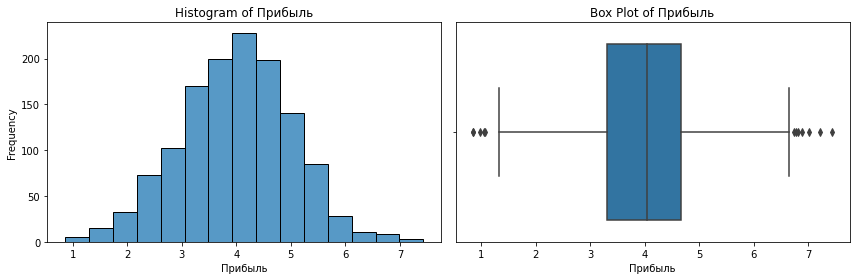

In [45]:
plot_histograms_boxplots(money)

В параметре `Прибыль` естб выбросы.

**Вывод**

- В данных присутствуют выбросы и наблюдается неравномерное распределение в данных.

Чтобы отобрать пользователей с покупательской активностью не менее трёх месяцев можно взять пользователей из таблицы `money`, так как данная таблица хранит данные о среднемесячной прибыли покупателя за последние 3 месяца. Так как в таблице нет значений равные 0 следовательно все пользователи совершали покупки в течении нужного срока.

<a id='объединение'></a>
## Объединение данных

- Объединим таблицы `market_file.csv`, `market_money.csv`, `market_time.csv`. Данные о прибыли из файла money.csv при моделировании нам не понадобятся. 
- Нужно учесть, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода.

In [46]:
# Проверка столбцов в market_money
market_money.columns

Index(['Период', 'Выручка'], dtype='object')

In [47]:
market_money.duplicated().sum()

742

In [48]:
# Развернем" по id, чтобы один id был только в одной строчке
market_money = market_money.pivot_table(
    index='id',                # Индексируем по 'id'
    columns='Период',           # Периоды становятся столбцами
    values='Выручка',           # Значения выручки
    aggfunc='sum'               # Если у нас есть несколько значений, их нужно агрегировать (например, суммировать)
)

# Переименовываем столбцы, добавляя суффикс 'Выручка_' к категориям 'Период_деньги'
market_money.columns = [f"Выручка_{col}" for col in market_money.columns]

# Проверим столбцы
market_money.shape

(1300, 3)

In [49]:
# Проверка столбцов в market_time
market_time.columns

Index(['Период', 'минут'], dtype='object')

In [50]:
market_time.duplicated().sum()

2561

In [51]:
# Развернем" по id, чтобы один id был только в одной строчке
market_time = market_time.pivot_table(
    index='id',                # Индексируем по 'id'
    columns='Период',           # Периоды становятся столбцами
    values='минут',             # Значения времени
    aggfunc='sum'               # Если есть несколько значений, агрегируем
)

# Переименовываем столбцы, добавляя суффикс 'Время_' к категориям 'Период_время'
market_time.columns = [f"Время_{col}" for col in market_time.columns]

# Проверим столбцы
market_time.shape

(1300, 2)

In [52]:
# Объединяем данные
df_full = market_file.join(market_money, on='id')
df_full = df_full.join(market_time, on='id')
df_full.head(10)

Покупательская_активность Тип_сервиса Разрешить_сообщать  Длительность  \
id                                                                              
215348                 Снизилась     премиум                 да           121   
215349                 Снизилась     премиум                 да           819   
215350                 Снизилась    стандарт                нет           539   
215351                 Снизилась    стандарт                 да           896   
215352                 Снизилась    стандарт                нет          1064   
215353                 Снизилась    стандарт                 да           762   
215354                 Снизилась    стандарт                 да           431   
215355                 Снизилась    стандарт                нет           284   
215356                 Снизилась    стандарт                 да           192   
215357                 Снизилась    стандарт                 да           154   

                  Популярная_категория  Средний_просмотр_категорий_за_визит  \
id                                                                            
215348                Товары для детей                                    6   
215349                Товары для детей                                    4   
215350               Домашний текстиль                                    5   
215351                Товары для детей                                    5   
215352                Товары для детей                                    3   
215353               Домашний текстиль                                    4   
215354           Косметика и аксесуары                                    2   
215355                Товары для детей                                    5   
215356           Косметика и аксесуары                                    2   
215357  Техника для красоты и здоровья                                    3   

        Ошибка_сервиса  Страниц_за_визит Маркет_актив_6_мес_категориальный  \
id                                                                           
215348               1                 5                           средний   
215349               2                 5                           средний   
215350               1                 5                           средний   
215351               6                 4                           средний   
215352               3                 2                           средний   
215353               1                 4                           средний   
215354               7                 2                           средний   
215355               6                 4                           средний   
215356               1                 3                           средний   
215357               9                 5                           средний   

       Маркет_актив_тек_мес_категориальный Акционные_покупки_категориальный  \
id                                                                            
215348                             высокий                           низкий   
215349                             средний                          высокий   
215350                              низкий                           низкий   
215351                             высокий                          высокий   
215352                              низкий                          высокий   
215353                             средний                           низкий   
215354                              низкий                           низкий   
215355                             средний                           низкий   
215356                             средний                           низкий   
215357                             высокий                           низкий   

       Неоплаченные_продукты_штук_квартал_категориальный  \
id                                                         
215348                                           средний   
215349             

In [53]:
df_full.shape

(1300, 17)

In [54]:
df_full.duplicated().sum()

11

In [55]:
# Удаляем дубликаты
df_full = df_full.drop_duplicates()

# Проверяем, что дубликаты удалены
df_full.duplicated().sum()

0

In [56]:
# Проверка на пропуски
df_full.isna().sum()

Покупательская_активность                            0
Тип_сервиса                                          0
Разрешить_сообщать                                   0
Длительность                                         0
Популярная_категория                                 0
Средний_просмотр_категорий_за_визит                  0
Ошибка_сервиса                                       0
Страниц_за_визит                                     0
Маркет_актив_6_мес_категориальный                    0
Маркет_актив_тек_мес_категориальный                  0
Акционные_покупки_категориальный                     0
Неоплаченные_продукты_штук_квартал_категориальный    0
Выручка_предыдущий_месяц                             3
Выручка_препредыдущий_месяц                          3
Выручка_текущий_месяц                                1
Время_предыдущий_месяц                               0
Время_текущий_месяц                                  0
dtype: int64

In [57]:
# Удаляем строки с пропущенными значениями
df_full.dropna(inplace=True)

In [58]:
# Проверка размерности
df_full.shape

(1285, 17)

In [59]:
# Проверка основной информации
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Покупательская_активность                          1285 non-null   object 
 1   Тип_сервиса                                        1285 non-null   object 
 2   Разрешить_сообщать                                 1285 non-null   object 
 3   Длительность                                       1285 non-null   int64  
 4   Популярная_категория                               1285 non-null   object 
 5   Средний_просмотр_категорий_за_визит                1285 non-null   int64  
 6   Ошибка_сервиса                                     1285 non-null   int64  
 7   Страниц_за_визит                                   1285 non-null   int64  
 8   Маркет_актив_6_мес_категориальный                  1285 non-null   object 
 9   М

С типами параметров всё в порядке. Объединение прошло успешно.

<a id='корреляционный'></a>
## Корреляционный анализ

- Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. 
- Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

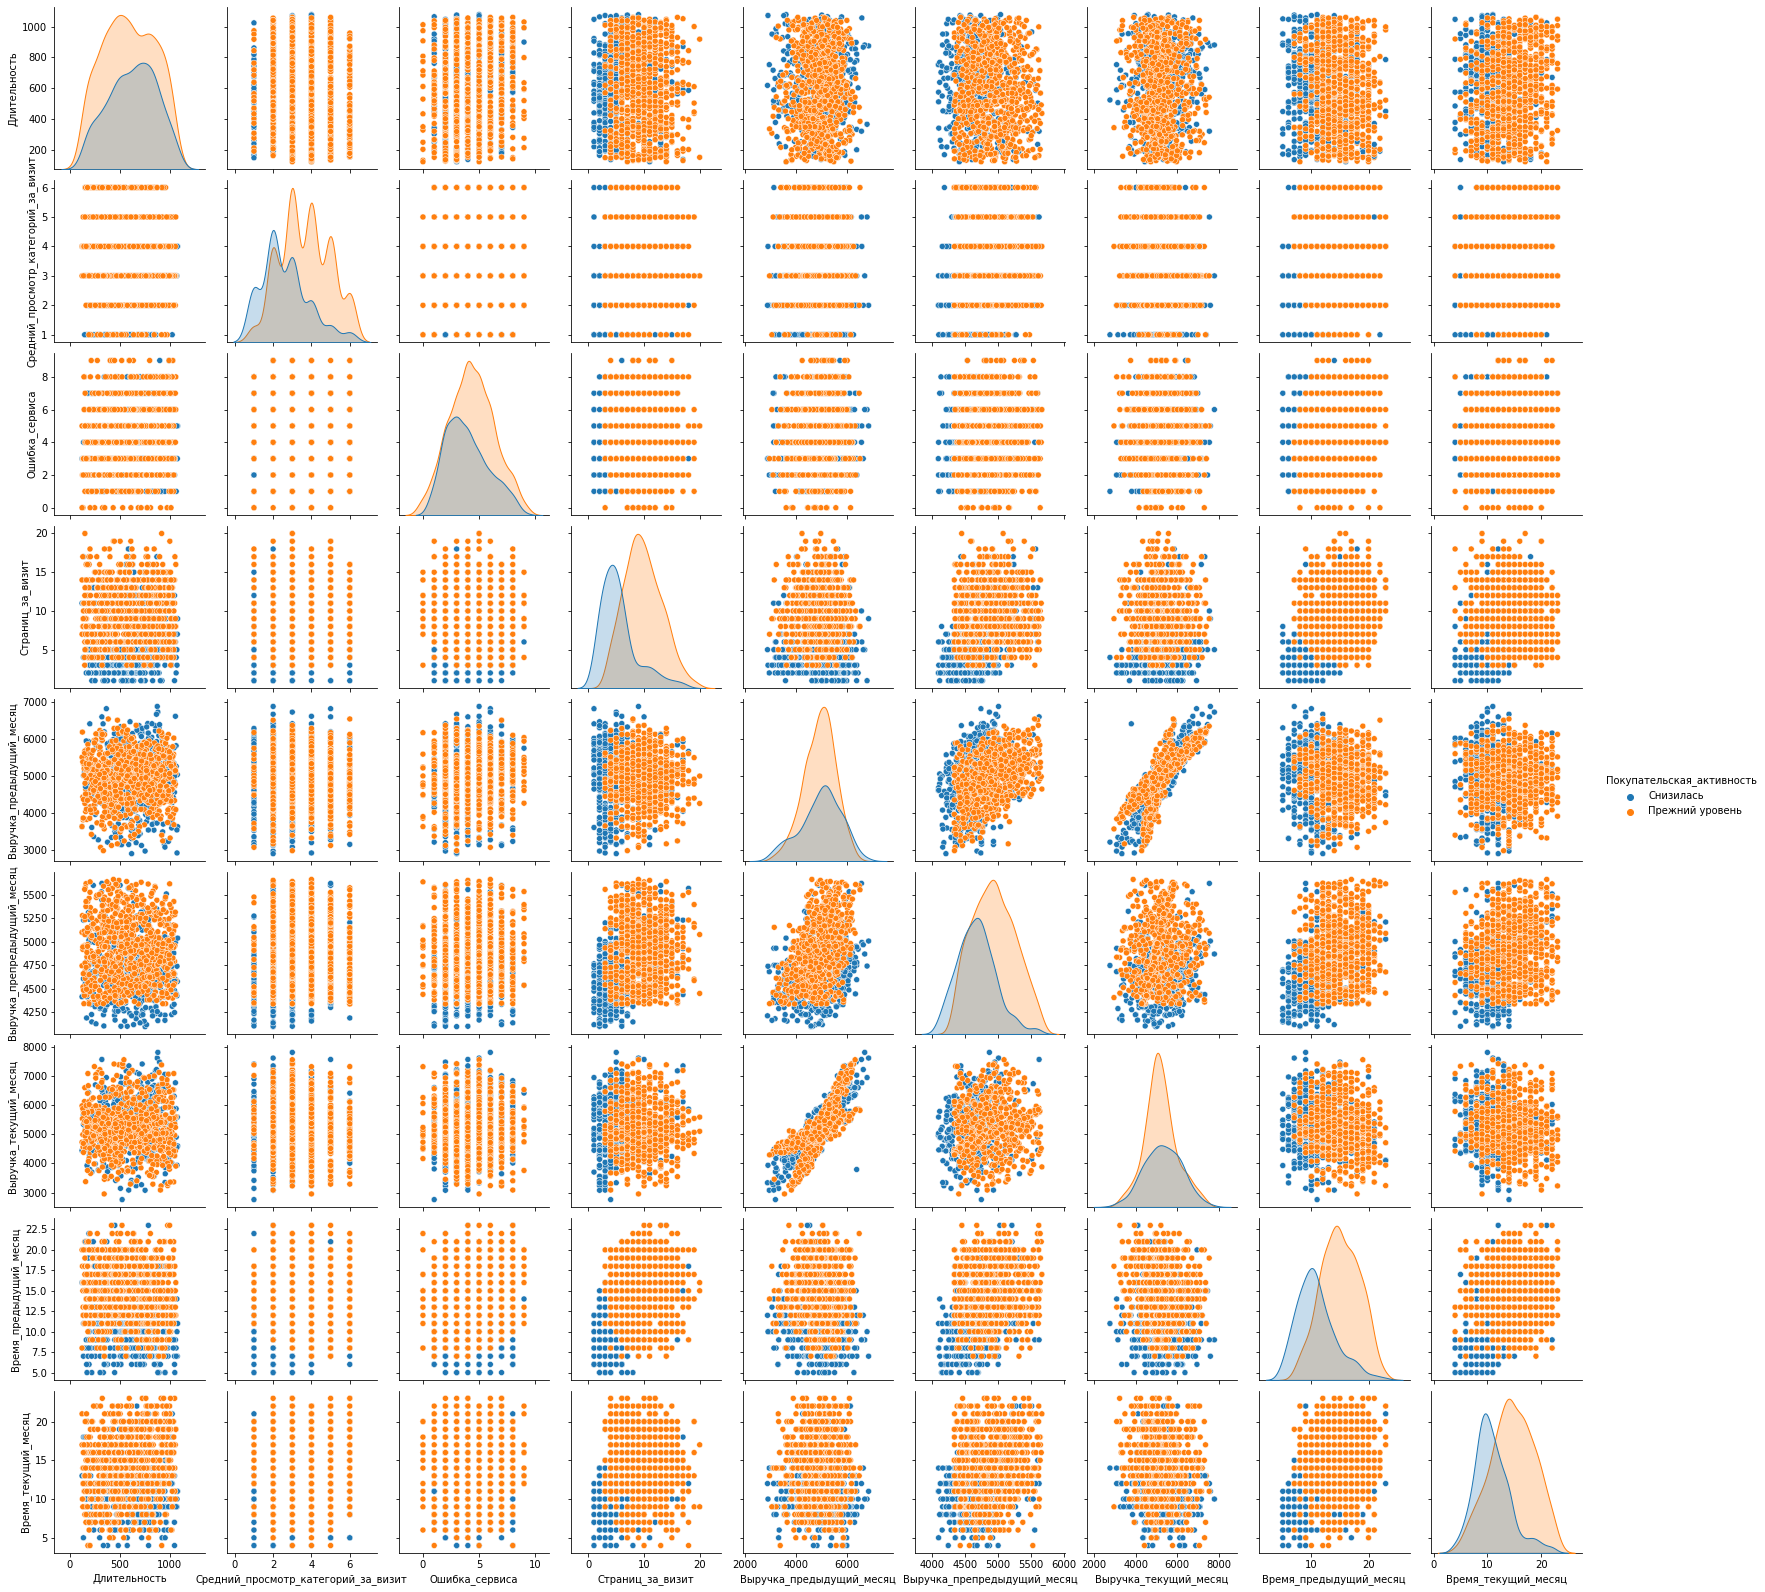

In [60]:
# Построение парных графиков для числовых переменных
# hue='Покупательская_активность' позволяет различать группы данных по цвету в зависимости от значения этого признака.
sns.pairplot(df_full, hue='Покупательская_активность')

# Отображение графиков
plt.show()

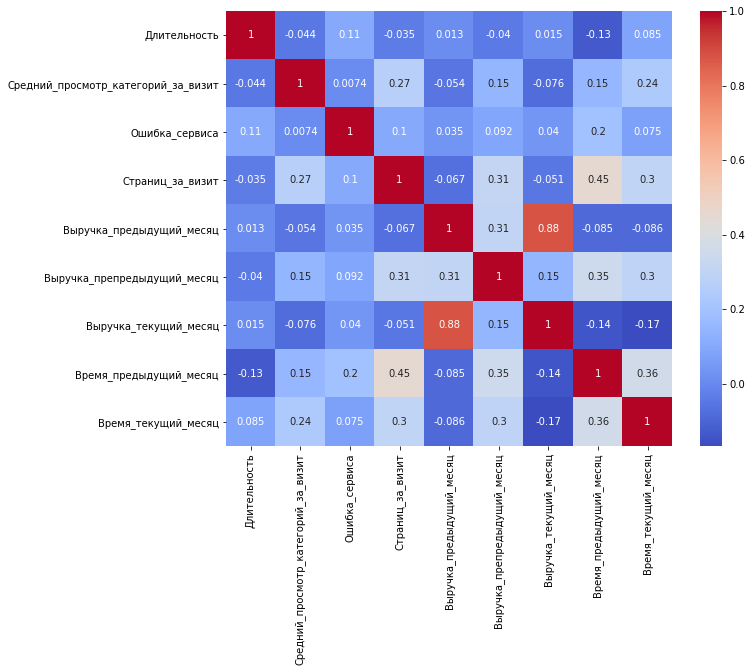

In [61]:
# Выбор только числовых столбцов из DataFrame
numeric_cols = df_full.select_dtypes(include=['number']).columns

# Вычисление корреляционной матрицы с использованием метода Спирмена
# Метод Спирмена используется для анализа монотонной зависимости между переменными, в отличие от стандартного метода Пирсона.
correlation_matrix = df_full[numeric_cols].corr(method='spearman')

# Построение тепловой карты для визуализации корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Корреляционная связь выше 0.75 не была найдена, значит нет мультиколлинеарности между признаками нет.

Попробуем Метод Phi-K, который используется для анализа корреляций между числовыми и категориальными признаками, помогает выявить не только линейные зависимости, но и более сложные (в том числе нелинейные) связи. 

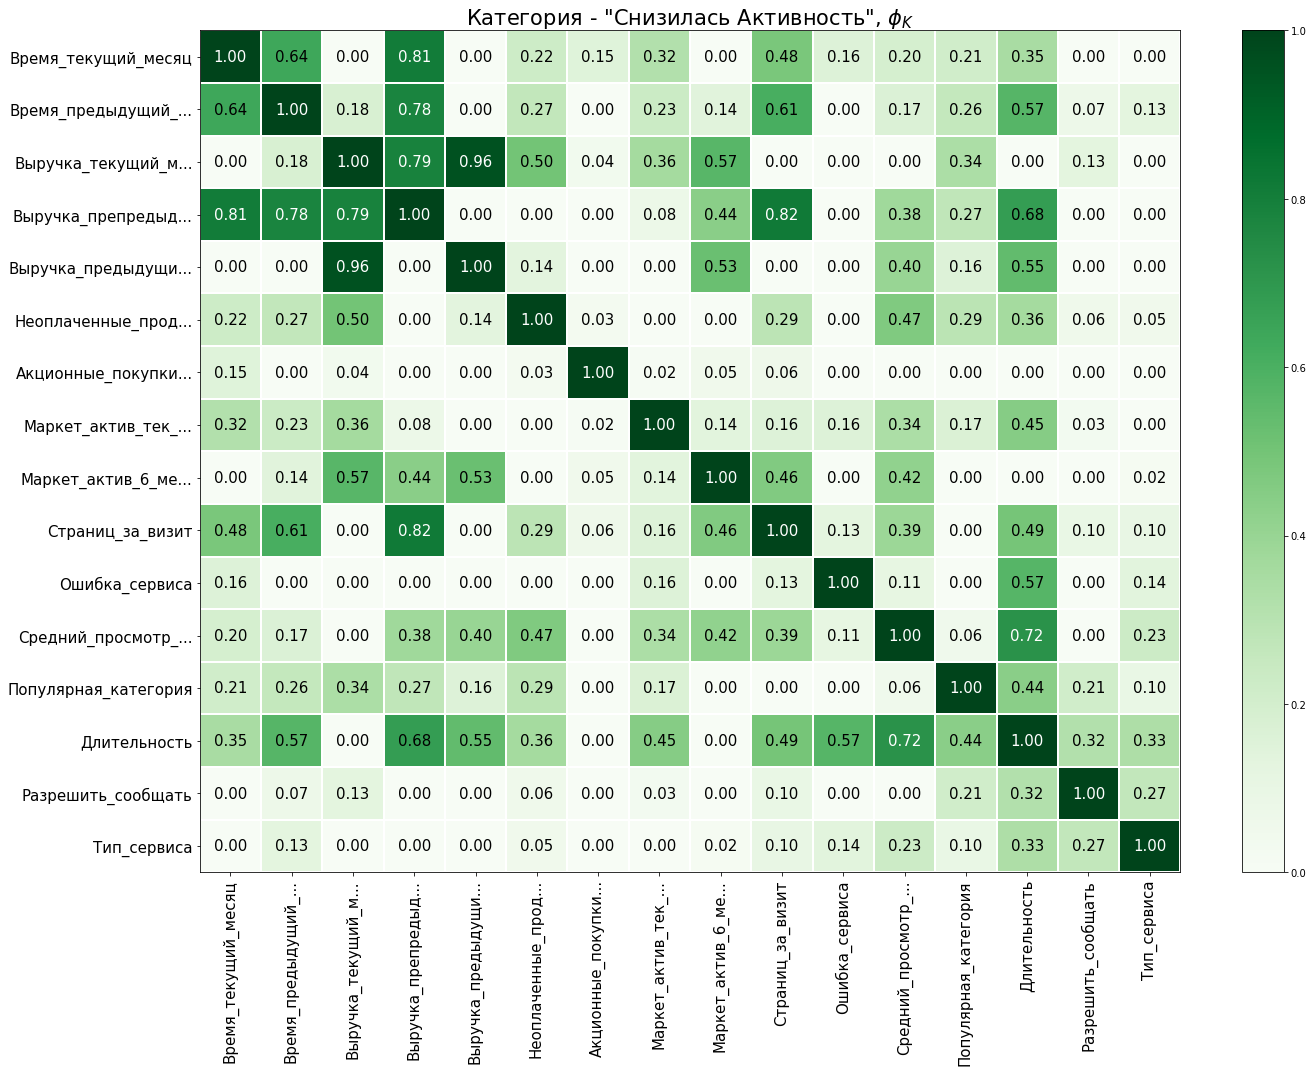

In [62]:
# Для категории "Снизилась активность"
# Фильтруем DataFrame по категории "Снизилась Активность" в столбце 'Покупательская активность' и удаляем этот столбец.
# Составляем матрицу корреляции Phi-K для числовых признаков в этой категории.
phik_overview_declined = phik_matrix(
    df_full[df_full['Покупательская_активность'] == 'Снизилась'].drop('Покупательская_активность', axis=1),  # Фильтрация и удаление столбца
    interval_cols=numeric_cols,  # Список числовых признаков для анализа
    bins=100  # Количество бинов (групп) для вычисления корреляции
)

# Строим тепловую карту корреляции для категории "Снизилась Активность".
# phik_overview_declined.values - матрица корреляции, полученная на предыдущем шаге
# x_labels и y_labels - метки для осей, используем имена столбцов из полученной матрицы
# Параметры vmin и vmax задают пределы для цветовой шкалы (от 0 до 1 для Phi-K)
# color_map задает цветовую схему, а title задает заголовок графика.
plot_correlation_matrix(
    phik_overview_declined.values,  # Значения корреляционной матрицы
    x_labels=phik_overview_declined.columns,  #ъ
    y_labels=phik_overview_declined.index,  
    vmin=0, vmax=1,  # Пределы цветовой шкалы
    color_map='Greens',  # Цветовая схема
    title='Категория - "Снизилась Активность", $\phi_K$',  
    fontsize_factor=1.5,  
    figsize=(20, 15)  
)

- `Выручка_текущий_месяц` сильно коррелирует с `Выручка_предпредыдущий_месяц`.
- `Выручка_предпредыдущий_месяц` сильно коррелирует с `Время_текущий_месяц`, `Время_предыдущий_месяц`,`Выручка_текущий_месяц` и `Страниц_за_визит`.

**Можно сделать следующие выводы:**

- В препредыдущий месяц, возможно, проходила акция, которая сильно повлияла на выручку;
- Признаки выручка за текущий месяц, а также минут текущий месяц - утечка, так как их можно зафиксировать только по прошествии месяца, для которого требуется предсказание;

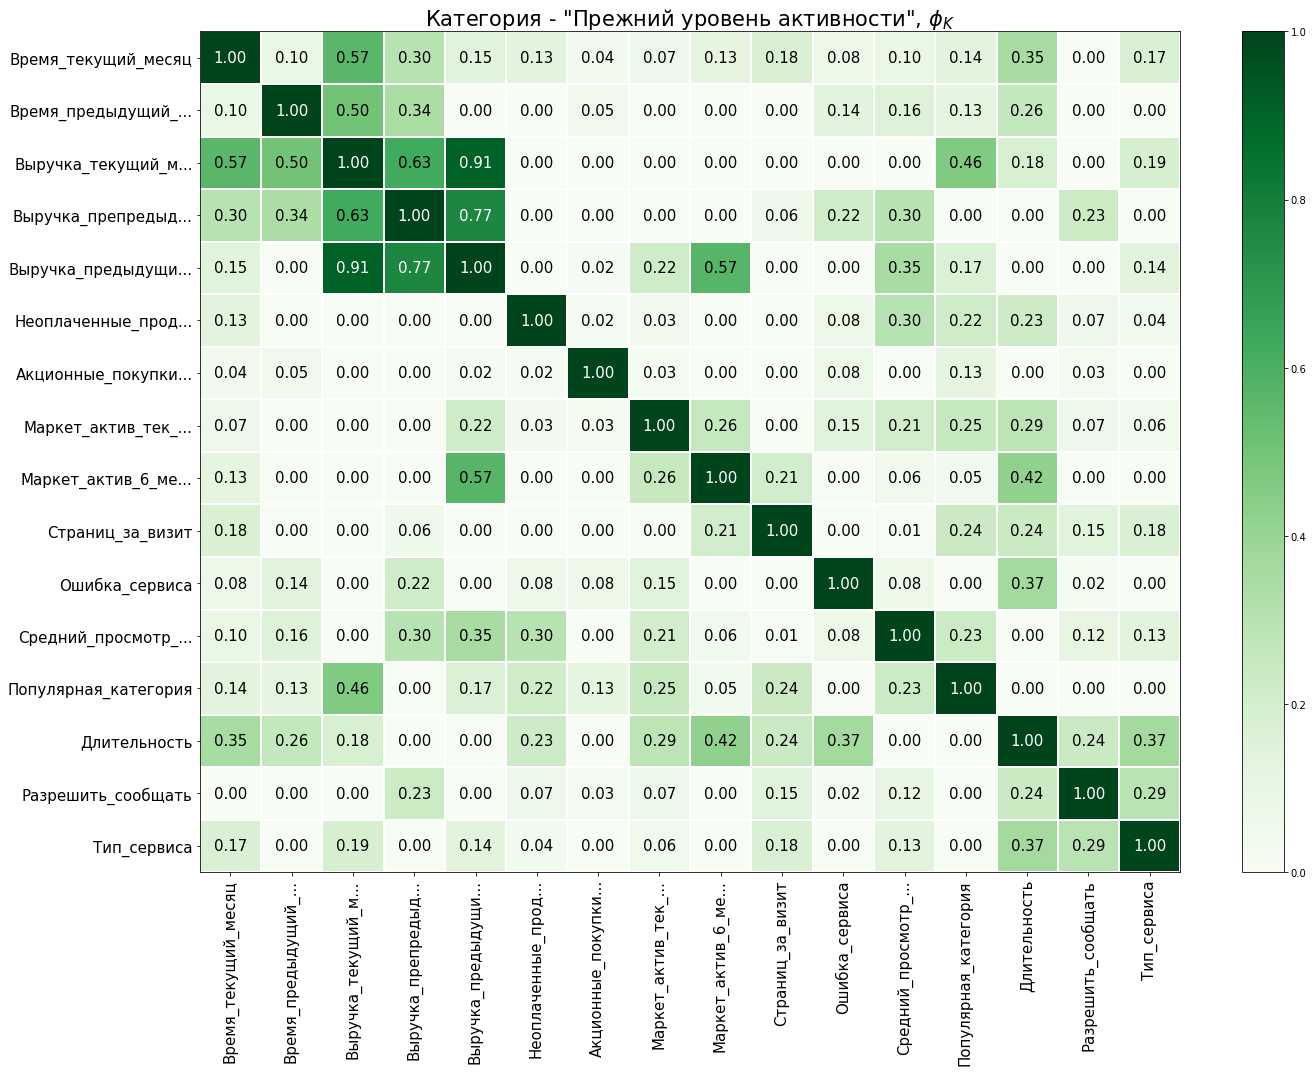

In [63]:
# Для категории "Активность Осталась Прежней"
# Фильтруем DataFrame по категории "Прежний уровень" в столбце 'Покупательская активность' и снова удаляем этот столбец.
# Составляем матрицу корреляции Phi-K для числовых признаков в этой категории.
phik_overview_stable = phik_matrix(
    df_full[df_full['Покупательская_активность']=='Прежний уровень'].drop(['Покупательская_активность'],axis=1), 
    interval_cols=numeric_cols, bins=100)

# Строим тепловую карту корреляции для категории "Прежний уровень активности".
# phik_overview_stable.values - матрица корреляции для этой категории
# x_labels и y_labels снова задаются на основе имен столбцов.
plot_correlation_matrix(
    phik_overview_stable.values,  # Значения корреляционной матрицы
    x_labels=phik_overview_stable.columns,  
    y_labels=phik_overview_stable.index, 
    vmin=0, vmax=1,  # Пределы цветовой шкалы
    color_map='Greens',
    title='Категория - "Прежний уровень активности", $\phi_K$',  
    fontsize_factor=1.5,  
    figsize=(20, 15)  
)

Удалим `Выручка_препредыдущий_месяц`, `Выручка_текущий_месяц` и `Время_текущий_месяц` из-за рисков утечки, а для других коррелирующих между собой параметров применим метод регуляризации. 

In [64]:
df_full = df_full.drop([
    'Выручка_препредыдущий_месяц',
    'Выручка_текущий_месяц',
    'Время_текущий_месяц'], axis=1)

df_full.head()

Покупательская_активность Тип_сервиса Разрешить_сообщать  Длительность  \
id                                                                              
215349                 Снизилась     премиум                 да           819   
215350                 Снизилась    стандарт                нет           539   
215351                 Снизилась    стандарт                 да           896   
215352                 Снизилась    стандарт                нет          1064   
215353                 Снизилась    стандарт                 да           762   

       Популярная_категория  Средний_просмотр_категорий_за_визит  \
id                                                                 
215349     Товары для детей                                    4   
215350    Домашний текстиль                                    5   
215351     Товары для детей                                    5   
215352     Товары для детей                                    3   
215353    Домашний текстиль                                    4   

        Ошибка_сервиса  Страниц_за_визит Маркет_актив_6_мес_категориальный  \
id                                                                           
215349               2                 5                           средний   
215350               1                 5                           средний   
215351               6                 4                           средний   
215352               3                 2                           средний   
215353               1                 4                           средний   

       Маркет_актив_тек_мес_категориальный Акционные_покупки_категориальный  \
id                                                                            
215349                             средний                          высокий   
215350                              низкий                           низкий   
215351                             высокий                          высокий   
215352                              низкий                          высокий   
215353                             средний                           низкий   

       Неоплаченные_продукты_штук_квартал_категориальный  \
id                                                         
215349                                           средний   
215350                                           средний   
215351                                            низкий   
215352                                           средний   
215353                                           средний   

        Выручка_предыдущий_месяц  Время_предыдущий_месяц  
id                                                        
215349                    5216.0                      12  
215350                    5457.5                       8  
215351                    6158.0                      11  
215352                    5807.5                       8  
215353                    4738.5                      10

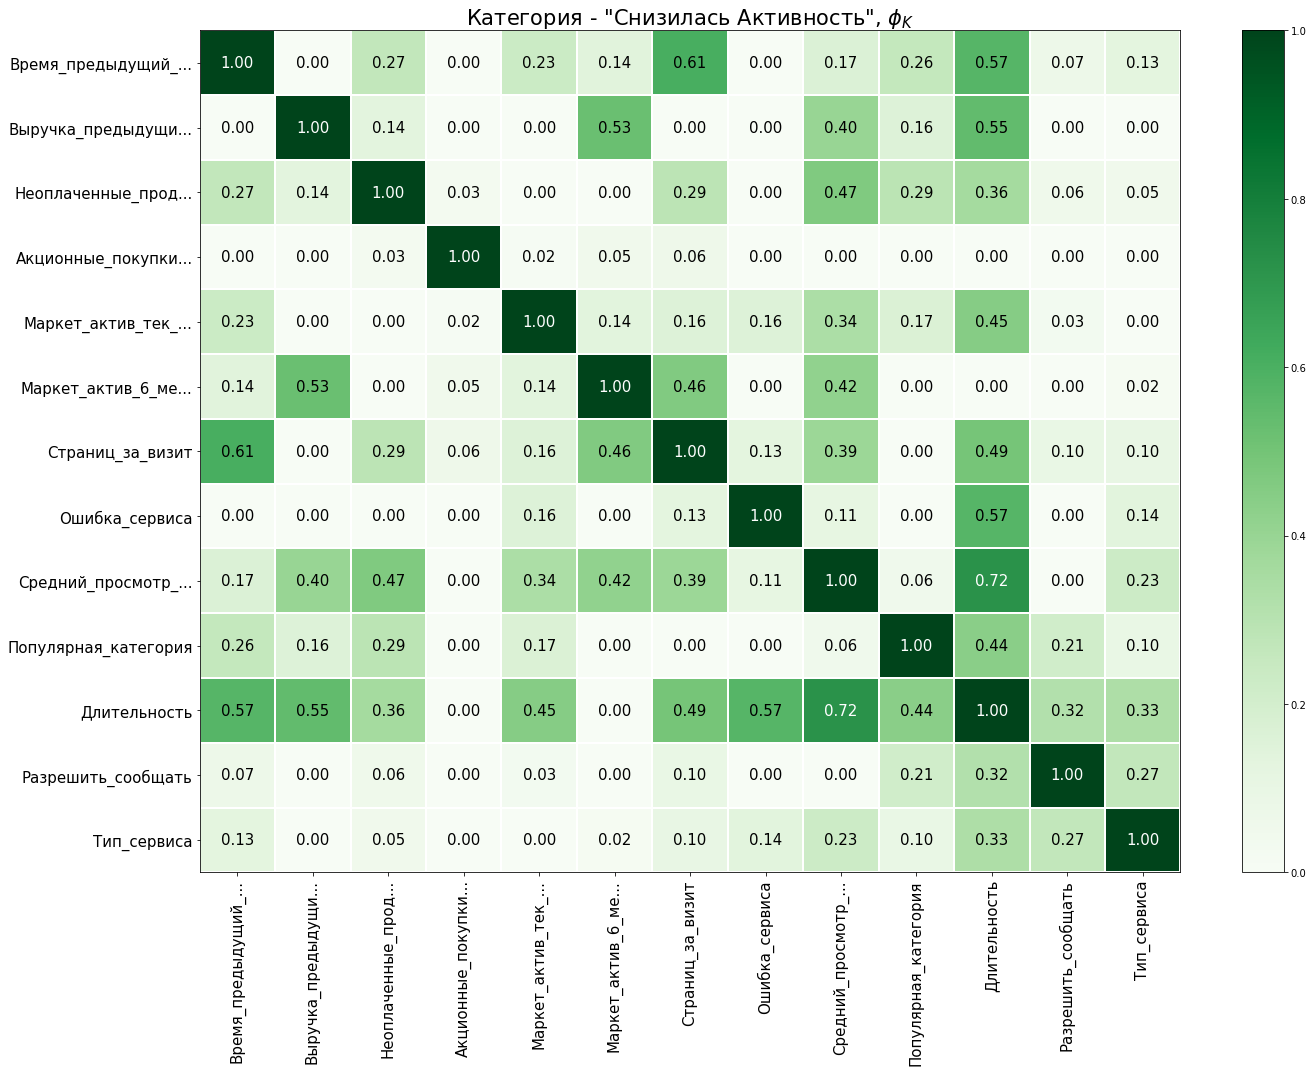

In [65]:
# Проверим корреляцию снова
phik_overview_declined = phik_matrix(
    df_full[df_full['Покупательская_активность'] == 'Снизилась'].drop('Покупательская_активность', axis=1),  # Фильтрация и удаление столбца
    interval_cols=numeric_cols,  # Список числовых признаков для анализа
    bins=100  # Количество бинов (групп) для вычисления корреляции
)

plot_correlation_matrix(
    phik_overview_declined.values,  # Значения корреляционной матрицы
    x_labels=phik_overview_declined.columns,  #ъ
    y_labels=phik_overview_declined.index,  
    vmin=0, vmax=1,  # Пределы цветовой шкалы
    color_map='Greens',  # Цветовая схема
    title='Категория - "Снизилась Активность", $\phi_K$',  
    fontsize_factor=1.5,  
    figsize=(20, 15)  
)

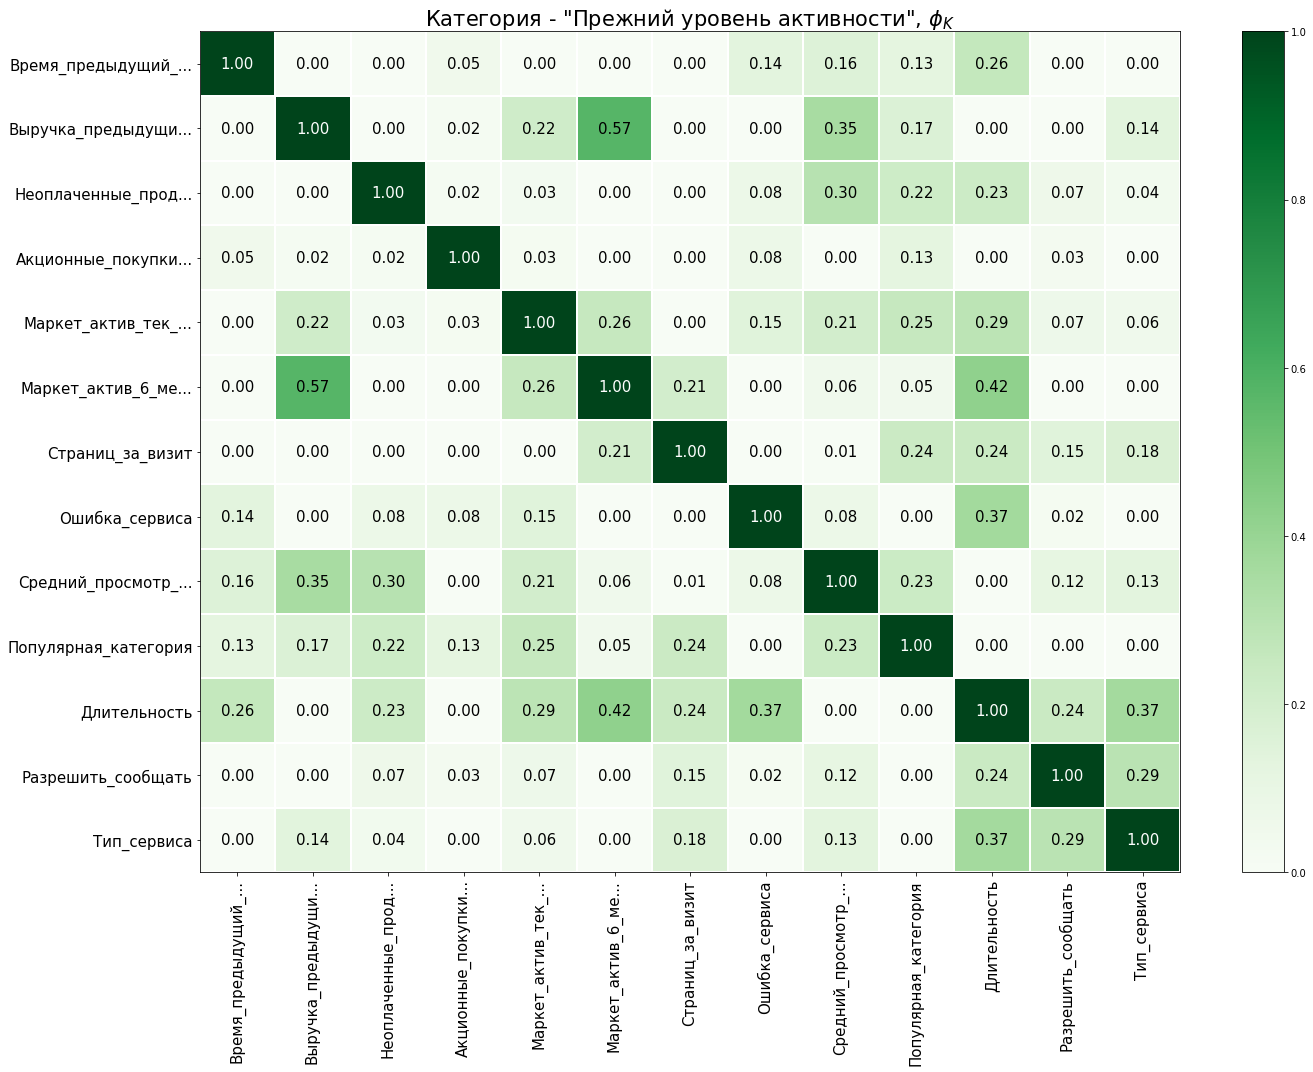

In [66]:
phik_overview_stable = phik_matrix(
    df_full[df_full['Покупательская_активность']=='Прежний уровень'].drop(['Покупательская_активность'],axis=1), 
    interval_cols=numeric_cols, bins=100)

# Строим тепловую карту корреляции для категории "Прежний уровень активности".
# phik_overview_stable.values - матрица корреляции для этой категории
# x_labels и y_labels снова задаются на основе имен столбцов.
plot_correlation_matrix(
    phik_overview_stable.values,  # Значения корреляционной матрицы
    x_labels=phik_overview_stable.columns,  
    y_labels=phik_overview_stable.index, 
    vmin=0, vmax=1,  # Пределы цветовой шкалы
    color_map='Greens',
    title='Категория - "Прежний уровень активности", $\phi_K$',  
    fontsize_factor=1.5,  
    figsize=(20, 15)  
)

Явной мультиколлинеарности нет.

<a id='построение'></a>
## Построение моделей с использованием пайплайнов

1. Используем ColumnTransformer для обработки количественных и категориальных признаков в пайплайне раздельно. Для кодирования атегориальных признаков применим как минимум два кодировщика, а для масштабирования количественных — два скейлера. Для каждой модели подготовим данные с разным кодированием и масштабированием.

2. Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой модели подберем хотя бы один гиперпараметр и выберем подходящую метрику для задачи, обосновав свой выбор. Мы будем использовать эту метрику при подборе гиперпараметров.

3. Выберем лучшую модель, используя заданную метрику, применяя одну из стратегий:

4. Используем пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель.

5. Используем один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернет нам лучшую модель.

Для данной задачи я выберу метрику **ROC-AUC**, так как она хорошо подходит для оценки качества классификации в задачах с несбалансированными классами, как это может быть в нашем случае с признаками "Покупательская_активность".

In [67]:
# Прверка данных перед обучением
detailed_df_analysis(df_full)

Пропущенные значения:
                                                   count  percentage
Покупательская_активность                              0         0.0
Тип_сервиса                                            0         0.0
Разрешить_сообщать                                     0         0.0
Длительность                                           0         0.0
Популярная_категория                                   0         0.0
Средний_просмотр_категорий_за_визит                    0         0.0
Ошибка_сервиса                                         0         0.0
Страниц_за_визит                                       0         0.0
Маркет_актив_6_мес_категориальный                      0         0.0
Маркет_актив_тек_мес_категориальный                    0         0.0
Акционные_покупки_категориальный                       0         0.0
Неоплаченные_продукты_штук_квартал_категориальный      0         0.0
Выручка_предыдущий_месяц                               0         0.0
Время_предыд

Верно, лучше удалить пропусаки, так как это неактивные пользователи.

In [68]:
# Инициализируем кодировщик меток для целевой переменной 'Покупательская_активность'
encoder = LabelEncoder()

# Определяем признаки (X) и целевую переменную (y)
X = df_full.drop(['Покупательская_активность'], axis=1)
y = df_full['Покупательская_активность']

# Разделяем данные на обучающую и тестовую выборки с использованием стратифицированного разбиения
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

# Обучаем энкодер только на обучающих данных
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)  # Преобразуем тестовую выборку


# Определяем категориальные и числовые столбцы
ohe_columns = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория','Акционные_покупки_категориальный']

ord_columns = ['Маркет_актив_6_мес_категориальный', 'Маркет_актив_тек_мес_категориальный',
               'Неоплаченные_продукты_штук_квартал_категориальный']

num_columns = ['Длительность', 'Средний_просмотр_категорий_за_визит', 'Ошибка_сервиса', 'Страниц_за_визит', 
               'Выручка_предыдущий_месяц', 'Время_предыдущий_месяц']

# Создаем ColumnTransformer для обработки различных типов данных
# OneHotEncoder для категориальных переменных, OrdinalEncoder для упорядоченных категорий и StandardScaler для числовых данных
data_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_columns),
    ('ord', OrdinalEncoder(), ord_columns),
    ('num', StandardScaler(), num_columns)
], remainder='passthrough')

# Создаем окончательный пайплайн, который включает подготовку данных и обучение модели
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Определяем сетку гиперпараметров для случайного поиска
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LogisticRegression (с L2 регуляризацией)
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, penalty='l2')],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC (с L2 регуляризацией и линейным ядром)
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel='linear')],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Линейное ядро
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC с RBF ядром
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel='rbf')],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# Инициализируем RandomizedSearchCV для подбора лучших гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_train, y_train) # Обучаем модель на обучающих данных

# Выводим лучшую модель и её параметры
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# Проверяем работу модели на тестовой выборке
# Прогнозируем вероятности для тестовой выборки
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать',
                                                   'Популярная_категория',
                                                   'Акционные_покупки_категориальный']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['Маркет_актив_6_мес_категориальный',
                                                   'Маркет_актив_тек_мес_категориальный',
                                                   'Неоплаченные_продукты_штук_квартал_категориальный']),
                                                 ('num', MinMaxScaler(),
    

Лучшая модель найдена, но модель показывает довольно высокие результаты. Проверим важность признаков.

<a id='анализ'></a>
## Анализ важности признаков

- Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP.
- Сделаем выводы о значимости признаков:

   - определим, какие признаки мало значимы для модели;
   - выявим признаки, которые сильнее всего влияют на целевой признак;
   - определим, как использовать эти наблюдения при моделировании и принятии бизнес-решений.

<Figure size 720x432 with 0 Axes>

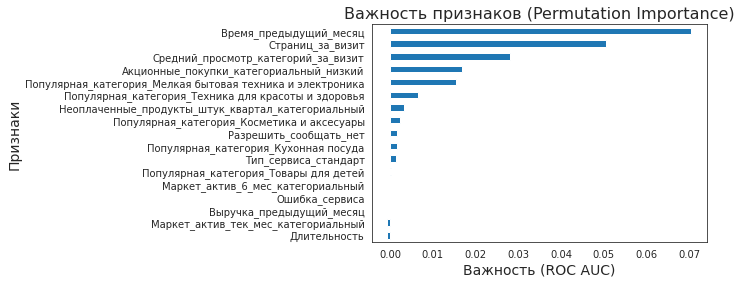

In [69]:
# Извлечение лучшей модели из результатов RandomizedSearchCV
best_model = randomized_search.best_estimator_.named_steps['models']

# Получаем этап предобработки
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

# Функция для оценки метрики ROC AUC
def custom_roc_auc(model, X, y):
    # Прогнозируем вероятности классов
    y_pred_proba = model.predict_proba(X)[:, 1]  # Мы берем вероятности для положительного класса (класс 1)
    score = roc_auc_score(y, y_pred_proba)
    return score

# Применяем предобработку к данным
X_test_preprocessed = preprocessor.transform(X_test)
X_train_preprocessed = preprocessor.transform(X_train)

# Получаем имена признаков после OneHotEncoder
ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns)

# Для OrdinalEncoder и StandardScaler можно использовать имена как есть
ord_feature_names = ord_columns
num_feature_names = num_columns

# Объединяем все имена признаков
all_feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

# Получаем результаты permutation_importance с кастомной метрикой
result = permutation_importance(best_model, X_test_preprocessed, y_test, scoring=custom_roc_auc, n_repeats=10, random_state=42)

# Создаем DataFrame для визуализации важности признаков
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,  # Здесь 'all_feature_names' — имена всех признаков
    'Importance': result['importances_mean']
})

# Сортируем по важности
feature_importance = feature_importance.sort_values('Importance', ascending=True)

# Визуализируем важность признаков
sns.set_style('white')
plt.figure(figsize=(10, 6))
feature_importance.plot(x='Feature', y='Importance', kind='barh', legend=False)
plt.title('Важность признаков (Permutation Importance)', fontsize=16)
plt.xlabel('Важность (ROC AUC)', fontsize=14)
plt.ylabel('Признаки', fontsize=14)
plt.show()

**Лидеры важности признаков:**

- Время_предыдущий_месяц
- Страниц_за_визит
- Средний_просмотр_категорий_за_визит

**Средние показатели у:**

- Акционные_покупки_категориальный_низкий
- Популярная категория_Мелкая бытовая техника и электроника

**Признаки с минимальным вкладом:**

- Популярная категория товары для детей: важность отсутсвует на графике.
- Маркет_актив_6_мес_категориальный: важность отсутсвует на графике.
- Ошибка сервиса: важность отсутсвует на графике.
- выручка предыдуший месяц: важность отсутсвует на графике.
- Маркет_актив_тек_мес_категориальный: минимальный вклад.
- Длительность: минимальный вклад.

Посмотрим, как признаки влияют на каждое предсказание модели:

  0%|          | 0/50 [00:00<?, ?it/s]

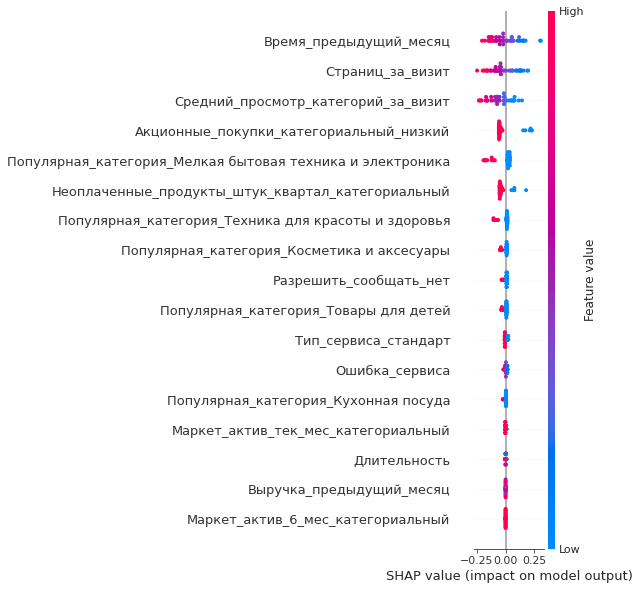

In [72]:
COUNT = 50

# Создаем DataFrame с нужными признаками для обучающей и тестовой выборки
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Семплируем данные для KernelExplainer
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, COUNT, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, COUNT, random_state=RANDOM_STATE)

# Теперь, когда у нас есть выборка, создаем KernelExplainer
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_smpl)

# Рассчитываем значения SHAP
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

# Строим график для бинарной классификации (используем только индекс 1 для положительного класса)
shap.summary_plot(shap_values[:, :, 1], X_test_preprocessed_smpl)

**Покупательскую активность снижают:**

- Большое значение времени предыдущего месяца.
- Высокие значения страниц за визит (красные точки вытягиваются влево): то есть меньше страниц за визит (короткие визиты) могут означать, что пользователь быстрее находит нужную информацию и покупает, что может быть связано с высокой покупательской активностью.
- Высокие значения среднего просмотра категорий за визит (красные точки вытягиваются влево): 
- Высокие значения популярной категории "Мелкая бытовая техника и электроника" (красные точки немного вытягиваются влево).

**Дополнения:**

- Низкий уровень акционных покупок: Высокие значения (красные точки) практически не влияют на снижение покупательской активности, однако их низкие значения (синие точки) могут положительно влиять на покупательскую активность.

- Неоплаченные продукты за квартал: Высокие значения (красные точки) также не оказывают значимого влияния на снижение активности, но их низкие значения (синие точки) могут способствовать увеличению покупательской активности.

<a id='сегментация'></a>
## Сегментация клиентов

- Рассмотрим сегментацию покупателей. Использовали результаты моделирования и данные о прибыльности покупателей для выполнения сегментации.

- Выберем группу покупателей и предложим способы увеличения их покупательской активности:

- Проведем графическое и аналитическое исследование выбранной группы покупателей.
- Сделаем предложения по работе с этим сегментом для увеличения их покупательской активности.

- Сделаем выводы о сегментах:

  - Укажем, какой сегмент мы выбрали для дополнительного исследования.
  - Опишем наши предложения и объясним, почему мы пришли к таким выводам.

Используем кривую Precision-Recall, где сможем найти порог, при котором точность и полнота наилучшим образом соответствуют бизнес-целям.

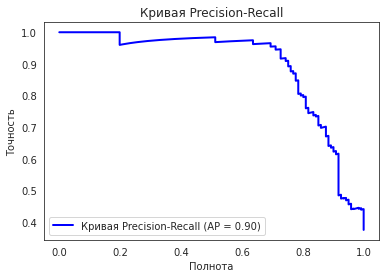

In [76]:
# Используем precision_recall_curve с явным указанием положительного класса
precision, recall, thresholds = precision_recall_curve(y_test_encoded, y_test_pred[:, 1], pos_label=1)

# Вычисляем среднюю точность
average_precision = average_precision_score(y_test_encoded, y_test_pred[:, 1])

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Кривая Precision-Recall (AP = %0.2f)' % average_precision)
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Кривая Precision-Recall')
plt.legend(loc="lower left")
plt.show()

In [ ]:
y_test.head()

Нужно выделить тех покупателей, для которых модель предсказала высокую вероятность снижения активности 

In [78]:
# Применяем порог для создания флагов
threshold = 0.8

# Применим модель для всех данных
best_model = randomized_search.best_estimator_
predictions = best_model.predict_proba(X)[:, 1]
prediction_flags = np.where(predictions > threshold, True, False)

In [79]:
# Выберем только те данные для которых модель предсказала снижение
df_decline = df_full.loc[prediction_flags]

# Добавить в эти данные инфу о прибыльности из таблицы money
df_decline = df_decline.join(money, on='id')

# Проверим что появился столбец
df_decline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 215349 to 216604
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Покупательская_активность                          233 non-null    object 
 1   Тип_сервиса                                        233 non-null    object 
 2   Разрешить_сообщать                                 233 non-null    object 
 3   Длительность                                       233 non-null    int64  
 4   Популярная_категория                               233 non-null    object 
 5   Средний_просмотр_категорий_за_визит                233 non-null    int64  
 6   Ошибка_сервиса                                     233 non-null    int64  
 7   Страниц_за_визит                                   233 non-null    int64  
 8   Маркет_актив_6_мес_категориальный                  233 non-null    object 
 9   Ма

Сравним сегментированных пользователей с остальными.

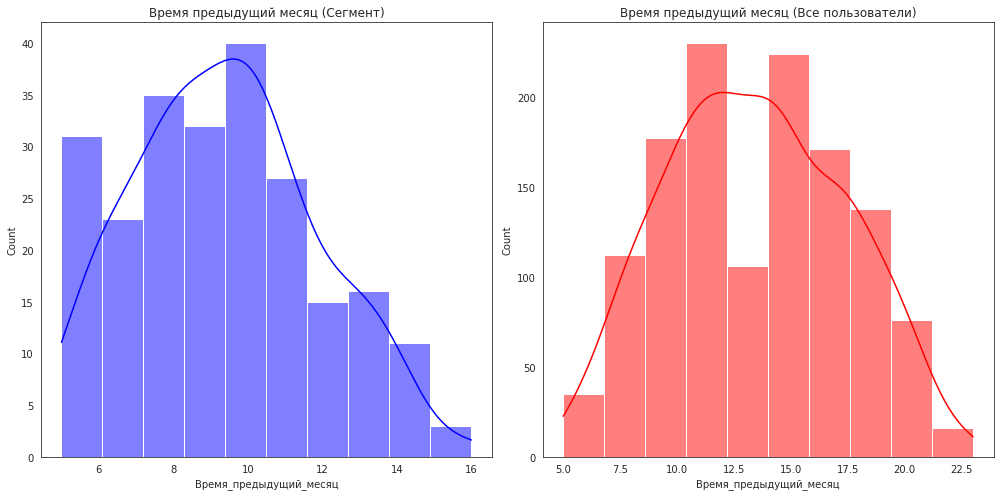

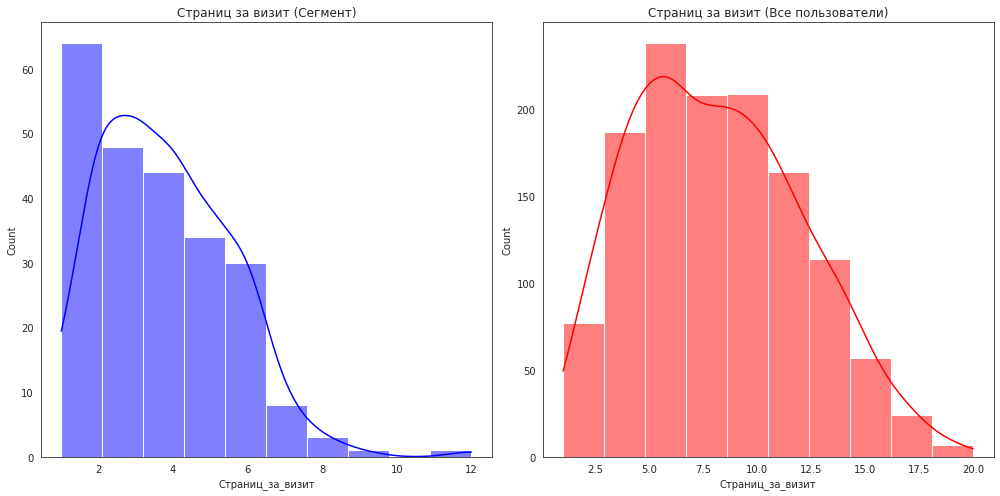

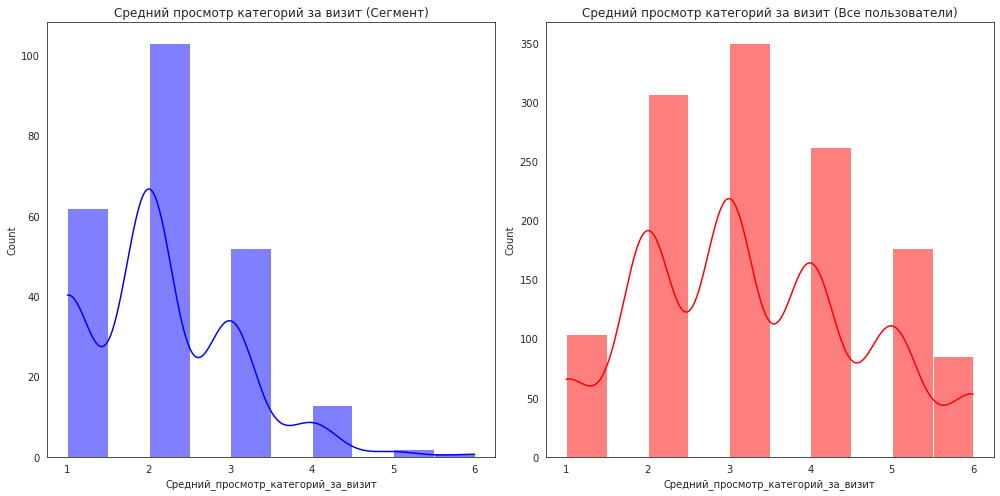

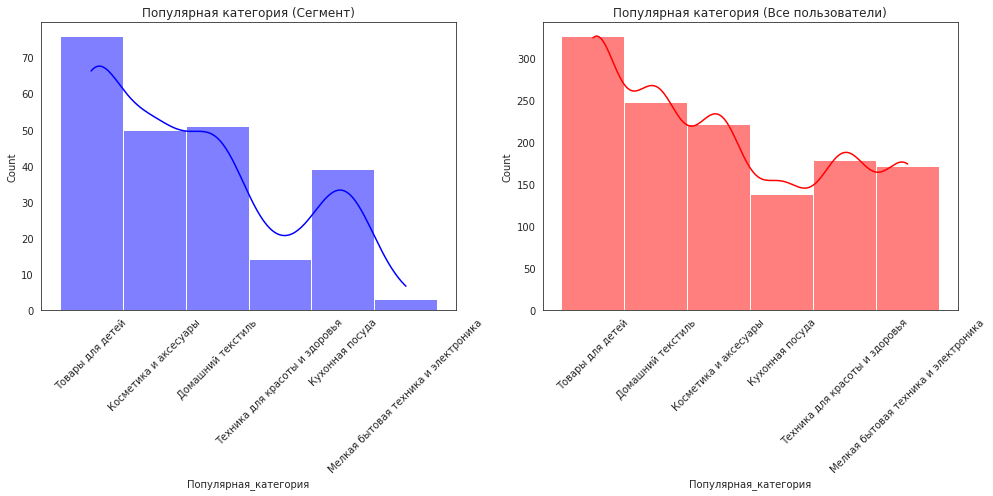

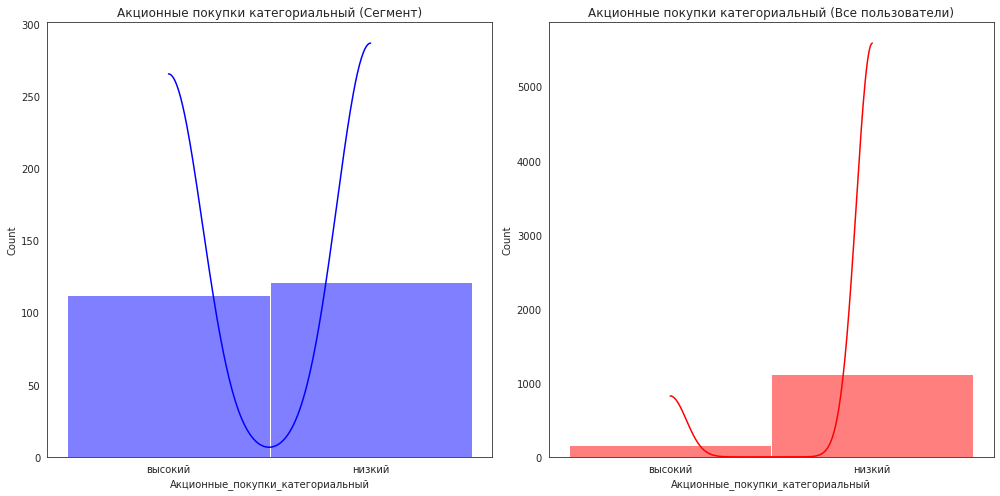

In [84]:
# Создаем первую фигуру с двумя графиками
plt.figure(figsize=(14, 7))

# Сравниваем 'Время_предыдущий_месяц' для выбранного сегмента и всех пользователей
plt.subplot(1, 2, 1)
sns.histplot(df_decline['Время_предыдущий_месяц'], bins=10, color='blue', kde=True)
plt.title('Время предыдущий месяц (Сегмент)')

plt.subplot(1, 2, 2)
sns.histplot(df_full['Время_предыдущий_месяц'], bins=10, color='red', kde=True)
plt.title('Время предыдущий месяц (Все пользователи)')

plt.tight_layout()
plt.show()

# Создаем вторую фигуру с двумя графиками
plt.figure(figsize=(14, 7))

# Сравниваем 'Страниц_за_визит' для выбранного сегмента и всех пользователей
plt.subplot(1, 2, 1)
sns.histplot(df_decline['Страниц_за_визит'], bins=10, color='blue', kde=True)
plt.title('Страниц за визит (Сегмент)')

plt.subplot(1, 2, 2)
sns.histplot(df_full['Страниц_за_визит'], bins=10, color='red', kde=True)
plt.title('Страниц за визит (Все пользователи)')

plt.tight_layout()
plt.show()

# Создаем третью фигуру с двумя графиками
plt.figure(figsize=(14, 7))

# Сравниваем 'Средний_просмотр_категорий_за_визит' для выбранного сегмента и всех пользователей
plt.subplot(1, 2, 1)
sns.histplot(df_decline['Средний_просмотр_категорий_за_визит'], bins=10, color='blue', kde=True)
plt.title('Средний просмотр категорий за визит (Сегмент)')

plt.subplot(1, 2, 2)
sns.histplot(df_full['Средний_просмотр_категорий_за_визит'], bins=10, color='red', kde=True)
plt.title('Средний просмотр категорий за визит (Все пользователи)')

plt.tight_layout()
plt.show()

# Создаем четвертую фигуру с двумя графиками
plt.figure(figsize=(14, 7))

# Сравниваем 'Популярная_категория' для выбранного сегмента и всех пользователей
plt.subplot(1, 2, 1)
sns.histplot(df_decline['Популярная_категория'], bins=10, color='blue', kde=True)
plt.title('Популярная категория (Сегмент)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.histplot(df_full['Популярная_категория'], bins=10, color='red', kde=True)
plt.title('Популярная категория (Все пользователи)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Создаем пятую фигуру с двумя графиками
plt.figure(figsize=(14, 7))

# Сравниваем 'Акционные_покупки_категориальный' для выбранного сегмента и всех пользователей
plt.subplot(1, 2, 1)
sns.histplot(df_decline['Акционные_покупки_категориальный'], bins=10, color='blue', kde=True)
plt.title('Акционные покупки категориальный (Сегмент)')

plt.subplot(1, 2, 2)
sns.histplot(df_full['Акционные_покупки_категориальный'], bins=10, color='red', kde=True)
plt.title('Акционные покупки категориальный (Все пользователи)')

plt.tight_layout()
plt.show()

**Согласно графику:**

- `Время_предыдущий_месяц`: Мы видим более скошенное вправо распределение у сегментированных пользователей с пиком на 10, в то время как у остальных пользователей более бимодальное распределение с разделением на тех, кто больше (с пиком на 11) и меньше (с пиком на 15) времени провел на сайте в предыдущем месяце. Это также может указывать на то, что в этой группе преобладают пользователи, которые меньше вовлечены в использование сайта, и их активность снизилась по сравнению с остальными.
- `Страниц_за_визит`: У обоих групп скошенное право распределение, но сегнментированная группа больше смещено влево по сравнению с общим группой. Это вполне может указывать на низкую вовлеченность и потенциально снижение активности у сегментированных пользователей.
- `Средний_просмотр_категорий_за_визит`: У сегментированной группы скошенное вправо распредление, в то время как у остльной группы более нормально распределение с небольшим сдвигом влево. 
- `Популярная_категория`:  У сегментированных пользователей менее популярны такие категории как "Техника для красоты и здоровья" и "Мелкая бытовая техника и электроника". У остальных пользователей категории этих товаров пользуются большим спросом. 
- `Акционные_покупки_категориальный`: У сегментированных пользователей акционные покупки выше, в то время как остльные пользователи покупают меньше акционных покупок. 

**Сегментированные покупатели:**

- Время в предыдущем месяце: Большинство пользователей, для которых предсказано снижение активности, провели в среднем 10 минут на сайте.
- Средний просмотр категорий за визит: Большинство пользователей, для которых предсказано снижение активности, просматривают в среднем всего 1-3 категории за визит.
- Высокий пик в районе 1 просмотра: Большинство пользователей, для которых предсказано снижение активности, просматривают в среднем 1 страницу за визит. 
- Разнообразие популярных категорий: Пользователи, для которых предсказано снижение активности, проявляют интерес к товарам для детей, домашнему текстилю, косметике и аксесурам и кухонной посуде. 
- Акционные покупки:  Пользователи, для которых предсказано снижение активности предпочитают покупать товары по акции.

<a id='общий'></a>
## Общий вывод

**Задача:**

Компания «В один клик» стремилась решить проблему снижения покупательской активности среди постоянных клиентов. Цель проекта заключалась в разработке модели, которая бы предсказывала вероятность снижения покупательской активности и помогала выделить клиентские сегменты для создания персонализированных предложений, способствующих повышению активности.

**Исходные данные и предобработка:**

Данные были получены из нескольких источников: `market_file.csv`, `market_money.csv` и `market_time.csv`. Прежде чем приступить к моделированию, была выполнена предобработка данных:

- Пропусков в данных не было, типы параметров соответствовали указанным в info().
- Параметры, такие как `Маркет_актив_6_мес`, `Акционные_покупки`, и другие, были переведены в категориальные из-за неправильного распределения.
- Обнаружены выбросы в некоторых параметрах (например, в параметре Выручка были удалены выбросы).
- Были объеденены таблицы market_file.csv, market_money.csv, market_time.csv.
- После объединения таблиц были обнаружены 3 пропуска и 11 дубликатов, которые тоже были удалены.
- Проведен корреляционный анализ с помощью корреляционной матрицы, выявлена сильная мультиколлиарность параметров `Выручка_препредыдущий_месяц`, `Выручка_текущий_месяц`, которые были удалены вместе с `Время_текущий_месяц` для устранения риска утечки. Для других параметров с средней коллиарностью использовалась регуляризация при обучении моделей.

**Для поиска лучшей модели использовался Pipeline с классификаторами:** 
- DecisionTreeClassifier, 
- KNeighborsClassifier, 
- LogisticRegression, 
- и SVC. 

Для подбора гиперпараметров применен **RandomizedSearchCV** с метрикой **ROC AUC** из-за дисбаланса классов. После настройки гиперпараметров лучшей моделью оказалась DecisionTreeClassifier, которая показала наилучшие результаты по метрике ROC AUC.

**Для улучшения интерпретации модели** был проведен анализ важности признаков с использованием Permutation Importance, в ходе которого были выделены 3 ключевых признака:

- Время_предыдущий_месяц
- Страниц_за_визит
- Средний_просмотр_категорий_за_визит

*Средние показатели у признаков:*

- Акционные_покупки_категориальный_низкий
- Популярная категория_Мелкая бытовая техника и электроника

**Выводы из анализа SHAP:**

На основе анализа SHAP выявлено, что факторы, снижающие покупательскую активность, включают:

- Большое значение времени предыдущего месяца.
- Высокие значения страниц за визит.
- Высокие значения среднего просмотра категорий за визит. 
- Высокие значения популярной категории "Мелкая бытовая техника и электроника".



**Сегментация клиентов:**

После сегментации клиентов с использованием порога 0.8 и применения модели для всех данных, были выделены клиенты с низкой активностью, для которых были добавлены данные о прибыльности из таблицы money. Также были выделены группы клиентов, наиболее подверженные снижению активности, на основе результатов анализа важности признаков:

- Большинство пользователей, для которых предсказано снижение активности, провели в среднем 10 минут на сайте.
- Большинство пользователей, для которых предсказано снижение активности, просматривают в среднем всего 1-3 категории за визит.
- Большинство пользователей, для которых предсказано снижение активности, просматривают в среднем 1 страницу за визит.
- Пользователи, для которых предсказано снижение активности, проявляют интерес к товарам для детей, домашнему текстилю, косметике и аксесурам и кухонной посуде.
- Пользователи, для которых предсказано снижение активности предпочитают покупать товары по акции.

**Рекомендации для бизнеса:**

- Персонализированные предложения: Создавайте предложения для пользователей с низкой активностью, основываясь на их интересах (детские товары, домашний текстиль, косметика и т.д.).

- Оптимизация акций: Разработайте дополнительные акции и скидки для пользователей, которые активно ищут товары по акции. Предложите ограниченные по времени акции или скидки на популярные товары с уведомлением, чтобы стимулировать их покупки.

- Улучшение вовлеченности: Для пользователей, которые проводят меньше времени на сайте и просматривают меньше категорий, стоит предложить улучшенную навигацию и рекомендации товаров на основе их предыдущих покупок. Также можно внедрить механизмы, которые помогут пользователям быстрее находить интересующие их товары, увеличивая их время пребывания на сайте.

- Упрощение выбора: Рекомендуйте товары пользователям с ограниченным просмотром страниц, чтобы ускорить процесс покупки, исходя из их предыдущих поисков, предпочтений и действий на сайте. 